In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/yolo-object-detection

/content/drive/MyDrive/yolo-object-detection


In [3]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### YOLO object detection in images

In [5]:
args = {
    "image": "images/baggage_claim.jpg",
    "yolo": "yolo-coco",
    "confidence": 0.5,
    "threshold": 0.3
}

In [6]:
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

In [8]:
weightsPath = ('/content/drive/MyDrive/yolo-object-detection/yolo-coco/yolov3.weights')
configPath = ('/content/drive/MyDrive/yolo-object-detection/yolo-coco/yolov3.cfg')

net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
print(weightsPath)
print(net)

/content/drive/MyDrive/yolo-object-detection/yolo-coco/yolov3.weights
< cv2.dnn.Net 0x7fc7138d5c90>


In [9]:
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.665763 seconds


In [10]:
boxes = []
confidences = []
classIDs = []

In [11]:

for output in layerOutputs:
	
	for detection in output:
		
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		
        
		if confidence > args["confidence"]:
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			
            
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			
      # update the list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [12]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
	args["threshold"])
print(idxs)

[ 1 14 22 19 17 28 40 23 24 43  3 20]


person
person: 0.9997
person
person: 0.9995
person
person: 0.9992
person
person: 0.9987
person
person: 0.9983
person
person: 0.9978
person
person: 0.9642
person
person: 0.6218


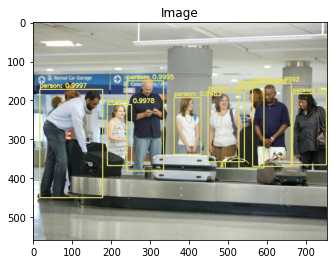

In [13]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extracting the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		
		if classIDs[i] == 0:
			print(LABELS[classIDs[i]])
			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			print(text)
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)

# show the output image
plt_imshow("Image", image)

In [14]:
print(len(boxes))
print(len(boxes))
print(len(confidences))

45
45
45


### YOLO object detection in video streams

In [15]:

args = {
    "input": "videos/me.mp4",
    "output": "output/pedestrian1.avi",
    "yolo": "yolo-coco",
    "confidence": 0.5,
    "threshold": 0.4
}

In [16]:
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


In [32]:
# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
writer = None
(W, H) = (None, None)

# determining the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

[INFO] 170 total frames in video


In [33]:
import argparse 
ap = argparse.ArgumentParser()
ap.add_argument("-b", "--buffer", type=int, default=64,
	help="max buffer size")
final = []
centers2 = []

while True:
	(grabbed, frame) = vs.read()
	if not grabbed:
		break

	
	if W is None or H is None:
		(H, W) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()
	boxes = []
	confidences = []
	classIDs = []

	
	for output in layerOutputs:
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > args["confidence"]:
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				centers2.append((centerX, centerY))

				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update the list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				final.append(boxes[0])
				print(final)
				confidences.append(float(confidence))
				classIDs.append(classID)
				print(boxes)

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"], args["threshold"])

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			if classIDs[i] == 0:
				cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
				text = "{}: {:.4f}".format(LABELS[classIDs[i]],
				confidences[i])
				cv2.putText(frame, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
				cv2.circle(frame, (centerX, centerY), 4, (0, 255, 0), -1)	
				print("tracking")
				
	centers3 = tuple(centers2)
	for i in range(1,len(centers3)):
			dX = centers3[-1][0] - centers3[i][0]
			dY = centers3[-1][1] - centers3[i][1]
			(dirX, dirY) = ("", "")
	 
			if np.abs(dX) > 20:
				dirX = "East" if np.sign(dX) == 1 else "West"
			if np.abs(dY) > 20:
				dirY = "North" if np.sign(dY) == 1 else "South"
			if dirX != "" and dirY != "":
				direction = "{}-{}".format(dirY, dirX)
			else:
				direction = dirX if dirX != "" else dirY

			thickness = int(np.sqrt(50 / float(i + 1)) * 2.5)
			cv2.line(frame, centers3[i - 1], centers3[i], (0, 0, 255), thickness)

	
	if writer is None:
		
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)
		

		
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))

	
	writer.write(frame)
  


print("[INFO] cleaning up...")
writer.release()
vs.release()
boxes
confidences


[INFO] single frame took 1.3998 seconds
[INFO] estimated total time to finish: 237.9625
[[-1, 62, 88, 405]]
[[-1, 62, 88, 405]]
tracking
[[-1, 62, 88, 405], [5, 44, 156, 439]]
[[5, 44, 156, 439]]
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439]]
[[5, 44, 156, 439], [2, 12, 95, 477]]
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439]]
[[5, 44, 156, 439], [2, 12, 95, 477], [1, 48, 100, 435]]
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439]]
[[5, 44, 156, 439], [2, 12, 95, 477], [1, 48, 100, 435], [1, 88, 99, 389]]
tracking
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [0, 25, 165, 456]]
[[0, 25, 165, 456]]
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [0, 25, 165, 456], [0, 25, 165, 456]]
[[0, 25, 165, 456], [5, 51, 154, 428]]
[[-1, 62, 88, 405], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 156, 439], [5, 44, 1

error: ignored

In [27]:
len(idxs)

0

In [28]:
import csv

with open("boxes.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(final)

The above code block takes a while to complete its execution. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming. 

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format. 

In [29]:
!ffmpeg -i "output/pedestrian1.avi" output4.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [30]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output4.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

In [ ]:
for j in range(0,len(frame)):
					cv2.imwrite('Frame'+str(j)+'.jpg', frame)
     
     